In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Your existing data loading functions (keeping them as-is)
def stocksData(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        dfTemp = pd.read_csv("data/stock_market_data-{}.csv".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['NaN'])
        dfTemp = dfTemp.rename(columns={'Close': symbol})
        df = df.join(dfTemp)
    return df

def loadData(stock, lookBack):
    data = []
    dataRaw = stock.values
    
    for i in range(len(dataRaw)-lookBack):
        data.append(dataRaw[i: i+lookBack])
        
    data = np.array(data)
    testSize = int(np.round(0.2*data.shape[0]))
    trainSize = data.shape[0]-testSize
    
    X_train = data[:trainSize,:-1,:]
    y_train = data[:trainSize,-1,:]
    X_test = data[trainSize:,:-1,:]
    y_test = data[trainSize:,-1,:]
    
    return X_train, X_test, y_train, y_test

# Enhanced Transformer model for stock prediction
class StockTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=3, output_dim=1, 
                 max_seq_len=100, dropout=0.1):
        super(StockTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_dim = input_dim
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = self._create_positional_encoding(max_seq_len, d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_dim)
        )
        
    def _create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project input to d_model dimensions
        x = self.input_projection(x) * np.sqrt(self.d_model)
        
        # Add positional encoding
        pos_encoding = self.pos_encoder[:, :seq_len, :].to(x.device)
        x = x + pos_encoding
        
        # Apply transformer encoder
        output = self.transformer_encoder(x)
        
        # Use the last time step for prediction
        output = output[:, -1, :]
        
        # Apply dropout and output projection
        output = self.dropout(output)
        output = self.output_projection(output)
        
        return output


In [16]:

# Training function
def train_transformer(model, train_loader, val_loader, device, num_epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)
    
    train_losses = []
    val_losses = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    return train_losses, val_losses

# Prediction and evaluation function
def evaluate_model(model, test_loader, device, scaler=None):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            predictions.extend(output.cpu().numpy())
            actuals.extend(target.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # If using scaler, inverse transform
    if scaler is not None:
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)
    
    return predictions, actuals


Using device: cuda
Data shape: (1258, 1)
Data range: 2020-01-02 00:00:00 to 2024-12-31 00:00:00
Training shapes: X_train: (966, 49, 1), y_train: (966, 1)
Testing shapes: X_test: (242, 49, 1), y_test: (242, 1)
Model parameters: 603,393
Starting training...


/home/mzhyui/git/finai/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Train Loss: 0.207405, Val Loss: 0.041537
Epoch 10: Train Loss: 0.003970, Val Loss: 0.000599
Epoch 20: Train Loss: 0.002610, Val Loss: 0.000433
Epoch 30: Train Loss: 0.002573, Val Loss: 0.000407
Epoch 40: Train Loss: 0.001995, Val Loss: 0.001047
Epoch 50: Train Loss: 0.001953, Val Loss: 0.000318
Epoch 60: Train Loss: 0.001962, Val Loss: 0.000385
Epoch 70: Train Loss: 0.001854, Val Loss: 0.000366
Epoch 80: Train Loss: 0.001785, Val Loss: 0.000411
Epoch 90: Train Loss: 0.001947, Val Loss: 0.000642


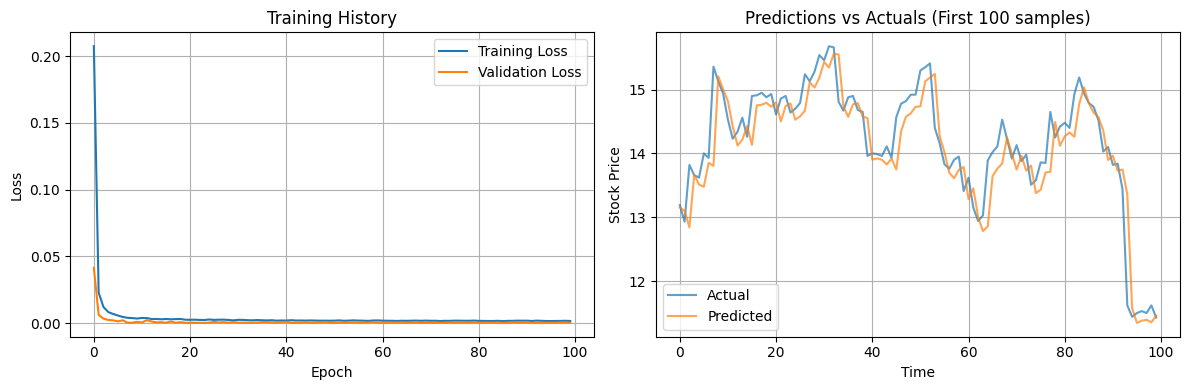


Model Performance:
MSE: 0.167653
RMSE: 0.409454
MAE: 0.289664
Model saved as 'stock_transformer_model.pth'


In [17]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and prepare data
dates = pd.date_range('2020-01-02', '2024-12-31', freq='B')
symbols = ['AAL']
df1 = pd.DataFrame(index=dates)
dfAAL = stocksData(symbols, dates)
dfAAL = df1.join(dfAAL)
dfAAL = dfAAL[['AAL']]
dfAAL = dfAAL.dropna()  # Remove NaN values

print(f"Data shape: {dfAAL.shape}")
print(f"Data range: {dfAAL.index[0]} to {dfAAL.index[-1]}")

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
dfAAL_scaled = pd.DataFrame(scaler.fit_transform(dfAAL), 
                            index=dfAAL.index, 
                            columns=dfAAL.columns)

# Create sequences
lookBack = 50
X_train, X_test, y_train, y_test = loadData(dfAAL_scaled, lookBack)
print(f"Training shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Convert to tensors
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

# Create data loaders
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create model
input_dim = X_train.shape[2]  # Number of features
model = StockTransformer(
    input_dim=input_dim,
    d_model=128,
    nhead=8,
    num_layers=3,
    output_dim=1,
    max_seq_len=lookBack,
    dropout=0.1
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train the model
print("Starting training...")
train_losses, val_losses = train_transformer(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    device=device,
    num_epochs=100,
    lr=0.001
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Make predictions
predictions, actuals = evaluate_model(model, test_loader, device, scaler)

# Plot predictions vs actuals
plt.subplot(1, 2, 2)
plt.plot(actuals[:100], label='Actual', alpha=0.7)
plt.plot(predictions[:100], label='Predicted', alpha=0.7)
plt.title('Predictions vs Actuals (First 100 samples)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate metrics
mse = np.mean((predictions - actuals) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - actuals))

print(f"\nModel Performance:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

# Save the model
torch.save(model.state_dict(), 'stock_transformer_model.pth')
print("Model saved as 'stock_transformer_model.pth'")



In [3]:
class MultiStepStockTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=3, 
                 output_steps=20, max_seq_len=100, dropout=0.1):
        super(MultiStepStockTransformer, self).__init__()
        
        self.d_model = d_model
        self.output_steps = output_steps
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = self._create_positional_encoding(max_seq_len, d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Multi-step output layers
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_steps)  # Direct multi-step output
        )
        
    def _create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_projection(x) * np.sqrt(self.d_model)
        
        # Add positional encoding
        pos_encoding = self.pos_encoder[:, :seq_len, :].to(x.device)
        x = x + pos_encoding
        
        # Apply transformer
        output = self.transformer_encoder(x)
        
        # Use last timestep for multi-step prediction
        output = output[:, -1, :]
        output = self.dropout(output)
        output = self.output_projection(output)  # Shape: (batch_size, output_steps)
        
        return output

In [4]:
def loadDataMultiStep(stock, lookBack, future_steps):
    """
    Create data for multi-step prediction training
    """
    data = []
    targets = []
    dataRaw = stock.values
    
    # Create sequences with multiple future targets
    for i in range(len(dataRaw) - lookBack - future_steps + 1):
        # Input sequence
        sequence = dataRaw[i:i + lookBack]
        # Multiple future targets
        future_targets = dataRaw[i + lookBack:i + lookBack + future_steps]
        
        data.append(sequence)
        targets.append(future_targets.flatten())  # Flatten to 1D
    
    data = np.array(data)
    targets = np.array(targets)
    
    # Split train/test
    testSize = int(np.round(0.2 * len(data)))
    trainSize = len(data) - testSize
    
    X_train = data[:trainSize]
    y_train = targets[:trainSize]
    X_test = data[trainSize:]
    y_test = targets[trainSize:]
    
    return X_train, X_test, y_train, y_test

In [5]:
def train_multistep_transformer(model, train_loader, val_loader, device, num_epochs=100):
    """
    Train model specifically for multi-step prediction
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass - predict all future steps at once
            output = model(data)  # Shape: (batch_size, future_steps)
            
            # Calculate loss across all future steps
            loss = criterion(output, target)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    return train_losses, val_losses

Multi-step data shapes:
X_train: (923, 100, 1), y_train: (923, 5)
X_test: (231, 100, 1), y_test: (231, 5)
Model parameters: 3,226,629
Epoch 0: Train Loss: 0.077017, Val Loss: 0.013141
Epoch 20: Train Loss: 0.004814, Val Loss: 0.002959
Epoch 40: Train Loss: 0.004170, Val Loss: 0.001691
Epoch 60: Train Loss: 0.003399, Val Loss: 0.001453
Epoch 80: Train Loss: 0.003586, Val Loss: 0.001224
Epoch 100: Train Loss: 0.003269, Val Loss: 0.001162
Epoch 120: Train Loss: 0.003507, Val Loss: 0.001099
Epoch 140: Train Loss: 0.003382, Val Loss: 0.001086
Epoch 160: Train Loss: 0.002921, Val Loss: 0.001080
Epoch 180: Train Loss: 0.003006, Val Loss: 0.001018


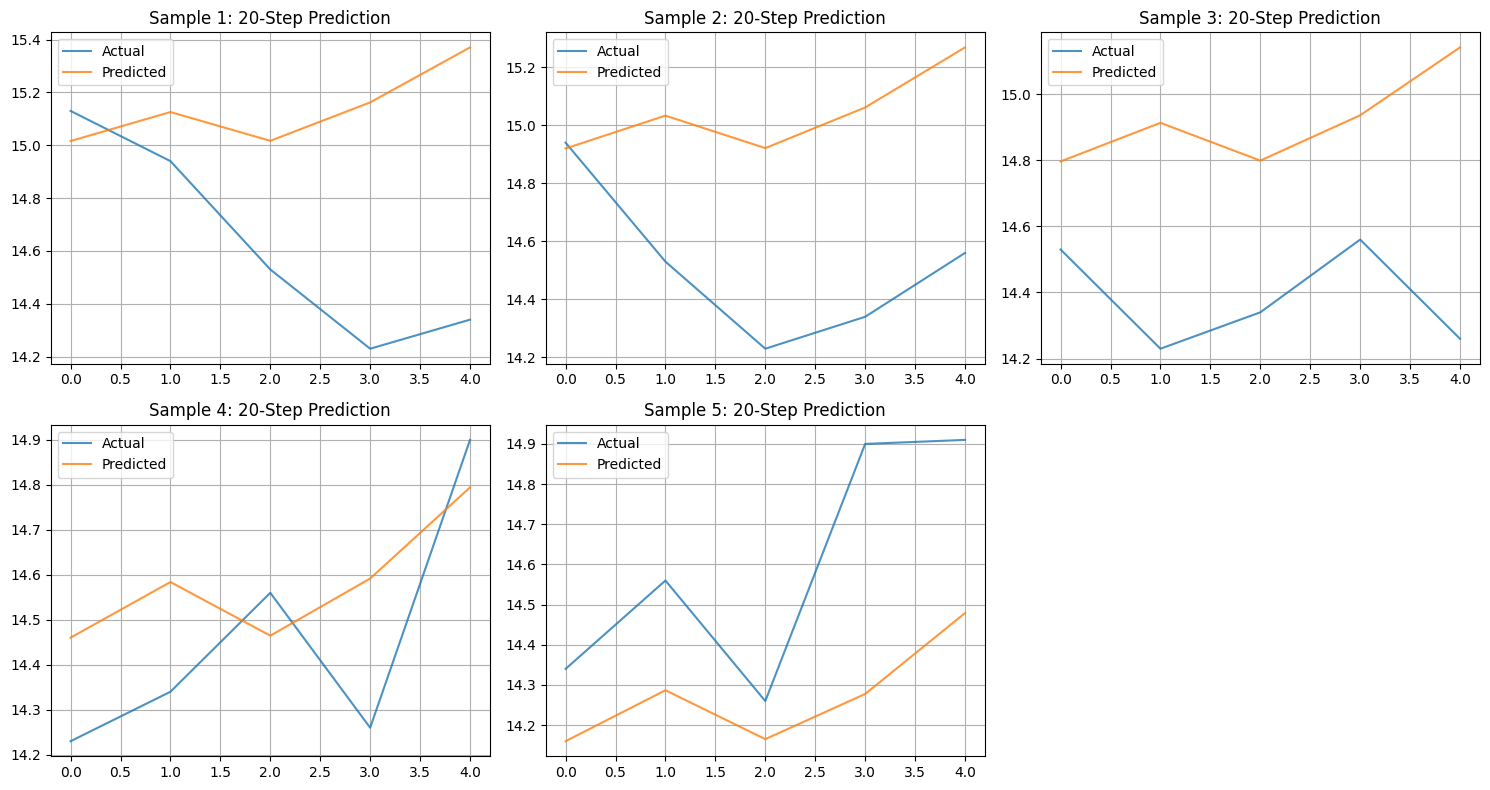

<Figure size 640x480 with 0 Axes>


Multi-Step Model Performance:
MSE: 0.481398
RMSE: 0.693828
MAE: 0.527020


In [23]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data (using your existing code)
dates = pd.date_range('2020-01-02', '2024-12-31', freq='B')
symbols = ['AAL']
df1 = pd.DataFrame(index=dates)
dfAAL = stocksData(symbols, dates)
dfAAL = df1.join(dfAAL)
dfAAL = dfAAL[['AAL']].dropna()

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dfAAL_scaled = pd.DataFrame(scaler.fit_transform(dfAAL), 
                            index=dfAAL.index, 
                            columns=dfAAL.columns)

# Create multi-step data
lookBack = 100
future_steps = 5
X_train, X_test, y_train, y_test = loadDataMultiStep(dfAAL_scaled, lookBack, future_steps)

print(f"Multi-step data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Create data loaders
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create multi-step model
model = MultiStepStockTransformer(
    input_dim=1,
    d_model=256,
    nhead=8,
    num_layers=4,
    output_steps=future_steps,
    max_seq_len=lookBack,
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train the model
train_losses, val_losses = train_multistep_transformer(
    model, train_loader, test_loader, device, num_epochs=200
)

# Evaluate
model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    test_actual = y_test.numpy()

# Inverse transform predictions
# Reshape for inverse transform
test_predictions_reshaped = test_predictions.reshape(-1, 1)
test_actual_reshaped = test_actual.reshape(-1, 1)

test_predictions_inv = scaler.inverse_transform(test_predictions_reshaped)
test_actual_inv = scaler.inverse_transform(test_actual_reshaped)

# Reshape back
test_predictions_inv = test_predictions_inv.reshape(test_predictions.shape)
test_actual_inv = test_actual_inv.reshape(test_actual.shape)

# Plot results
plt.figure(figsize=(15, 8))

# Plot a few examples
for i in range(0, min(5, len(test_predictions_inv)), 1):
    plt.subplot(2, 3, i+1)
    plt.plot(test_actual_inv[i], label='Actual', alpha=0.8)
    plt.plot(test_predictions_inv[i], label='Predicted', alpha=0.8)
    plt.title(f'Sample {i+1}: 20-Step Prediction')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# Calculate metrics
mse = np.mean((test_predictions_inv - test_actual_inv) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_predictions_inv - test_actual_inv))

print(f"\nMulti-Step Model Performance:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")


Predicting for sample 1/231...
Predicting for sample 51/231...
Predicting for sample 101/231...
Predicting for sample 151/231...
Predicting for sample 201/231...


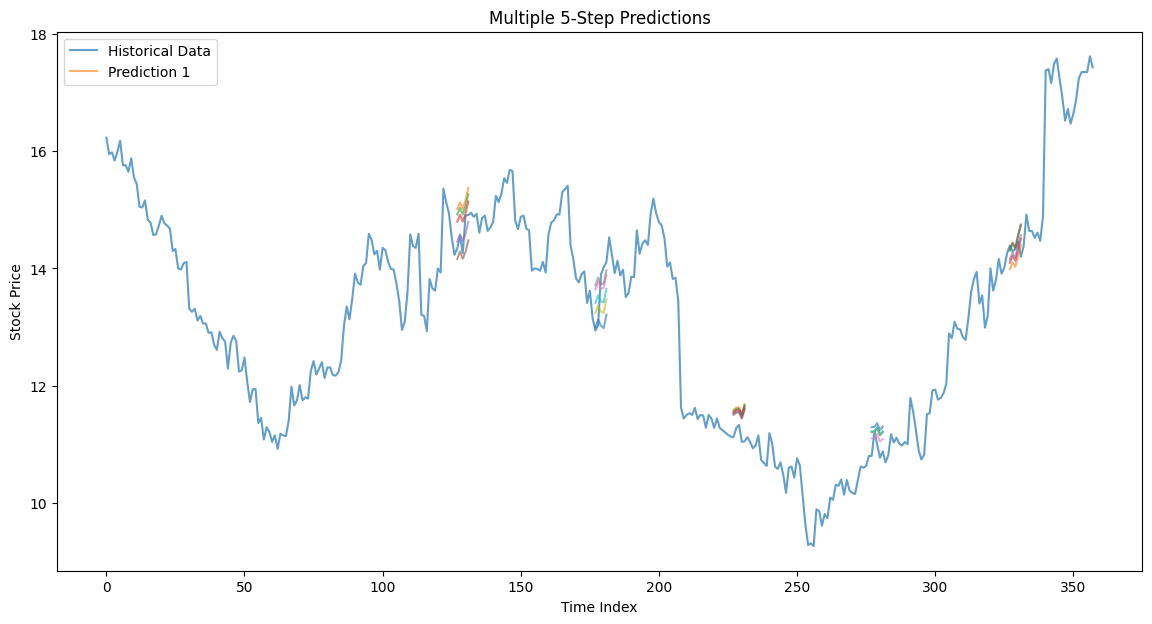

In [ ]:
def enhanced_multi_step_prediction(model, X_seq, future_steps, device, scaler):
    """
    Predict future_steps for each sequence in X_seq using the model.
    Returns: list of np.ndarray, each shape (future_steps, 1)
    """
    model.eval()
    X_seq = X_seq.to(device)
    with torch.no_grad():
        preds = model(X_seq)  # (batch, future_steps)
        preds = preds.cpu().numpy()
    # Inverse transform each prediction sequence
    preds_inv = []
    for i in range(preds.shape[0]):
        pred_seq = preds[i].reshape(-1, 1)
        pred_seq_inv = scaler.inverse_transform(pred_seq)
        preds_inv.append(pred_seq_inv)
    return preds_inv

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(dfAAL_scaled[900:]), label='Historical Data', alpha=0.7)

future_steps = model.output_steps
# X_test = torch.FloatTensor(X_train[-len(actuals):])  # Use X_test if available, else fallback
start_idx = 0
end_idx = len(X_test)

for j in range(start_idx, end_idx, 50):
    print(f"Predicting for sample {j+1}/{len(X_test)}...")
    future_preds = enhanced_multi_step_prediction(model, X_test[j:j+10], future_steps, device, scaler)
    for i in range(min(5, len(future_preds))):
        future_index = range(len(dfAAL_scaled[900:]) - len(X_test) + j, len(dfAAL_scaled[900:]) - len(X_test) + j + future_steps)
        plt.plot(future_index, future_preds[i], alpha=0.6, label=f'Prediction {j+i+1}' if j == 0 and i == 0 else None)

plt.legend()
plt.title(f'Multiple {future_steps}-Step Predictions')
plt.xlabel('Time Index')
plt.ylabel('Stock Price')
plt.show()